In [1]:
# Copyright 2020 IITK EE604A Image Processing. All Rights Reserved.
# 
# Licensed under the MIT License. Use and/or modification of this code outside of EE604 must reference:
#
# © IITK EE604A Image Processing 
# https://github.com/ee604/ee604_assignments
#
# Author: Shashi Kant Gupta, Cheeranjeev and Prof K. S. Venkatesh, Department of Electrical Engineering, IIT Kanpur

# Task 4 (Bonus Question): Using Optical Flow and Pinhole Camera Model to Estimate Camera Motion

---

## Theory
In this bonus task you have to implement Optical Flow algorithm to estimate motion of the camera. Recall that images captured by a camera is a 2D projection of a 3D point on the camera's image sensor. By using pinhole camera model we can approximately determine the relationship between this 3D coordinate point to 2D point on the image plane. This relationship is:

$$
[x', y']^T = \frac{f}{z}[x, y]^T
$$

Here, $x'$ and $y'$ is 2D projection of 3D point $P = [x, y, z]^T$ on the image plane and $f$ is the focal length of the camera. If you want to study in detail about camera model follow this [link](https://web.stanford.edu/class/cs231a/course_notes/01-camera-models.pdf)

### Optical flow
Optical flow is the apparent motion of image object between two consecutive frames due to the relative motion between the camera and the object. In a layman term, optical flow is velocity of certain pixel point on the image. Consider the example given below:
![](https://github.com/ee604/ee604_assignments/raw/master/assignment_1/imgs/t4_1.png)

In the example given above you can see the the pixel velocity for the green object will be $[2/\Delta t, 1/\Delta t]^T$. Where $\Delta t = t_2 - t_1$. Basically, this pixel velocity is the optical flow for the green object. For a more formal defination, you can check this [link](https://en.wikipedia.org/wiki/Optical_flow)

### Estimating camera velocity from optical flow
Now come back to the pinhole camera model. If we somehow calculate the camera distance from the object (i.e. $z$), we can easily estimate the motion of the green object with relative to the camera. Let's this relative velocity is $[v_x, v_y]^T$, then: 

$$
[v_x, v_y]^T = \frac{z}{f}[\Delta x'/\Delta t, \Delta y'/\Delta t]^T = \frac{z}{f}[2/\Delta t, 1/\Delta t]^T
$$
 
As we know, the green object was at rest. The motion of the camera will be $[-v_x, -v_y]^T$. This was just an intuitive explanation. And there exist numbers of different method to estimate optical flow. Also in actual implementation we do not calculate camera velocity using only one but instead we estimate the camera velocity by multiple points and then take the average.

---

## Your Task
Given an input video with some **N** number of known static objects. Estimate the camera motion. We have simplified the problem for you, the sample video contains 10 objects on a white background, all the 10 objects are either red i.e. image location having value `[255, 0, 0]`, blue (`[0, 0, 255]`), or green (`[0, 255, 0]`) in RGB notation. Following are the other usefull parameters.

* focal length $f = 10mm$
* Perpendicular distance of the camera from the scene, i.e. $z = 60cm$
* $\Delta t$: You do not need this. Hint: you know how to calculate fps for a video right?

**Calculate the camera motion ($v_{cx}$ and $v_{cy}$) in $cm/s$ and plot $v_{cx}$ vs $t$ and $v_{cy}$ vs $t$ plot**

**Note:** You are not allowed to use openCV module. Focus on the basics and you will be able to implement it.

In [2]:
%%bash
pip install git+https://github.com/ee604/ee604_plugins

  Cloning https://github.com/ee604/ee604_plugins to /tmp/pip-req-build-v9gnodbn
  Created wheel for ee604-plugins: filename=ee604_plugins-0.1.4-cp36-none-any.whl size=2305 sha256=e81c33babe8b8680bda9e0211cb847be29ad7db2806da6ddd24210062eb5c07f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9bvaq8jb/wheels/34/a8/1d/ae3b7d209ecde89b4800a47ec55a61e7503bb9548bbb975806
Successfully built ee604-plugins


  Running command git clone -q https://github.com/ee604/ee604_plugins /tmp/pip-req-build-v9gnodbn


In [3]:
# Importing required libraries

import cv2
import numpy as np
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

from ee604_plugins import download_dataset, playVideo

download_dataset(assignment_no=1, task_no=4)

Download Complete!


In [4]:
# This is the video
playVideo("data/optical_flow.mp4", width=600, height=600)

In [5]:
def calculate_motion(video_path, video_length=50, f=1, z=60):
    '''
    Write a program to change the quantisation level of the given image to 2^quantisation_bit levels. 
    In this one you have to use uniform quantisation.
    
    Inputs:                      
    + video - path to the video file using which you will estimate camera motion
    + video_length - this is the length of your video in secs
    + f - focal length
    + z - perpendicular distance of the camera from objects
    
    Ouputs:
    + v_cx - camera velocity in x direction at time 't'
    + v_cy - camera velocity in y direction at time 't'
    + t - time 't'
    
    Allowed external package:
    + You must not use any direct implementation of optical flow
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    c = f/z
    vid = cv2.VideoCapture(video_path)
    Xr, Yr = [], []
    Xg, Yg = [], []
    Xb, Yb = [], []
    nframe = 0

    while(1):
        # reading from video 
        ret, frame = vid.read() 

        if ret:
            # Taking centroid of all Red circles
            loc = np.where((frame[:,:,0] == 255) & (frame[:,:,1] == 0) & (frame[:,:,2] == 0)) 
            tpixels = len(loc[0]) # Total pixels forming the figure
            Xr.append(round(np.sum(loc[1]/tpixels))) # X geometric centre
            Yr.append(round(np.sum(loc[0]/tpixels))) # Y geometric centre

            # Green circles
            loc = np.where((frame[:,:,0] == 0) & (frame[:,:,1] == 255) & (frame[:,:,2] == 0)) 
            tpixels = len(loc[0]) # Total pixels forming the figure
            Xg.append(round(np.sum(loc[1]/tpixels))) # X geometric centre
            Yg.append(round(np.sum(loc[0]/tpixels))) # Y geometric centre

            # Blue circles
            loc = np.where((frame[:,:,0] == 0) & (frame[:,:,1] == 0) & (frame[:,:,2] == 255)) 
            tpixels = len(loc[0]) # Total pixels forming the figure
            Xb.append(round(np.sum(loc[1]/tpixels))) # X geometric centre
            Yb.append(round(np.sum(loc[0]/tpixels))) # Y geometric centre
            
            nframe += 1
        else: 
            break
    
    fps = nframe // video_length # vid.get(cv2.CAP_PROP_FPS)

    t = np.arange(nframe)
    v_cx, v_cy = np.zeros(nframe), np.zeros(nframe)

    for i in range(1, nframe):
        v_cx[i] = - c * fps * (Xr[i] - Xr[i-1] + Xg[i] - Xg[i-1] + Xb[i] - Xb[i-1]) / 3
        v_cy[i] = - c * fps * (Yr[i] - Yr[i-1] + Yg[i] - Yg[i-1] + Yb[i] - Yb[i-1]) / 3

    #############################
    # End your code here ########
    #############################
    
    return v_cx, v_cy, t

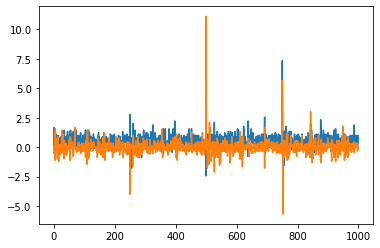

In [6]:
v_cx, v_cy, t = calculate_motion("data/optical_flow.mp4")

plt.plot(t, v_cx, label="v_cx")
plt.plot(t, v_cy, label="v_cy")
plt.show()